# Simulate Data

## Packages

In [33]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import os
import numpy as np

## Simulate Data

In [34]:
def simulate_gp_response(
    likelihood_type="gaussian", 
    sample_size=1000, 
    nugget=0.1, 
    marginal_variance=1.0, 
    custom_lengthscales=None, 
    seed=1
):
    """
    Simulate response and input variables from a Gaussian Process.

    Parameters:
    - likelihood_type: str, "gaussian" or "bernoulli-logit" for the likelihood.
    - sample_size: int, number of samples to generate.
    - nugget: float, noise variance (nugget).
    - marginal_variance: float, marginal variance (outputscale).
    - custom_lengthscale: list or tensor, custom length scales for each input dimension.
    - seed: int, random seed for reproducibility.

    Returns:
    - X: torch.Tensor, input variables.
    - sampled_field: torch.Tensor, simulated response.
    """

    torch.manual_seed(1)

    # Step 1: Define the Gaussian Process Model
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super().__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])  # Enable ARD
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # Step 2: Dummy Training Data
    train_x = torch.rand(100, custom_lengthscales.shape[1])  # Small dummy train set
    train_y = torch.zeros(100)    # Dummy target values

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
    model = ExactGPModel(train_x, train_y, likelihood)

    # Step 3: Set Custom Length Scales
    model.covar_module.base_kernel.lengthscale = custom_lengthscales

    # Adjust Marginal Variance (Outputscale)
    model.covar_module.outputscale = marginal_variance

    # Adjust Nugget (Noise Variance)
    if nugget is not None and likelihood_type == "gaussian":
        likelihood.noise = nugget  

    # Step 4: Switch to Evaluation Mode
    model.eval()
    likelihood.eval()

    # Step 5: Generate a Large Input Dataset
    n_points = sample_size  # Large dataset
    input_dim = custom_lengthscales.shape[1]
    X = torch.rand(n_points, input_dim)

    # Step 6: Sample from the GP Prior Without Constructing Full Covariance
    with torch.no_grad():
        latent_values = model(X).sample()

        if likelihood_type == "gaussian":
            sampled_field = latent_values
            probs = None  # No probabilities for Gaussian
        elif likelihood_type == "bernoulli-logit":
            # Convert latent values to probabilities using the sigmoid function
            probs = torch.sigmoid(latent_values)
            # Simulate binary responses based on probabilities
            sampled_field = torch.bernoulli(probs)
        else:
            raise ValueError("likelihood_type must be 'gaussian' or 'bernoulli-logit'.")
        
    return X, sampled_field, probs


## Examples with plots

In [43]:
example = False

### Gaussian

In [44]:
if example:
    X, y, _ = simulate_gp_response("gaussian",10000, 0.3, 1.0, torch.tensor([(0.25, 0.50,0.75,1.00,1.25)]),1)

    os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
    # Convert to numpy for easier plotting
    X_np = X
    y_np = y

    # Calculate the number of rows and columns for the subplot grid
    n_features = X_np.shape[1]
    n_rows = int(np.ceil(n_features / 1))
    n_cols = min(n_features, 1)
    # Create a figure with subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Create scatter plots for each input dimension
    for i in range(n_features):
        axs[i].scatter(X_np[:, i], y_np, alpha=0.5)
        axs[i].set_xlabel(f'Input Dimension {i+1}')
        axs[i].set_ylabel('Response')
        axs[i].set_title(f'Input Dim {i+1} vs Response')

    # Remove any unused subplots
    for i in range(n_features, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()
    

### Bernoulli-logit

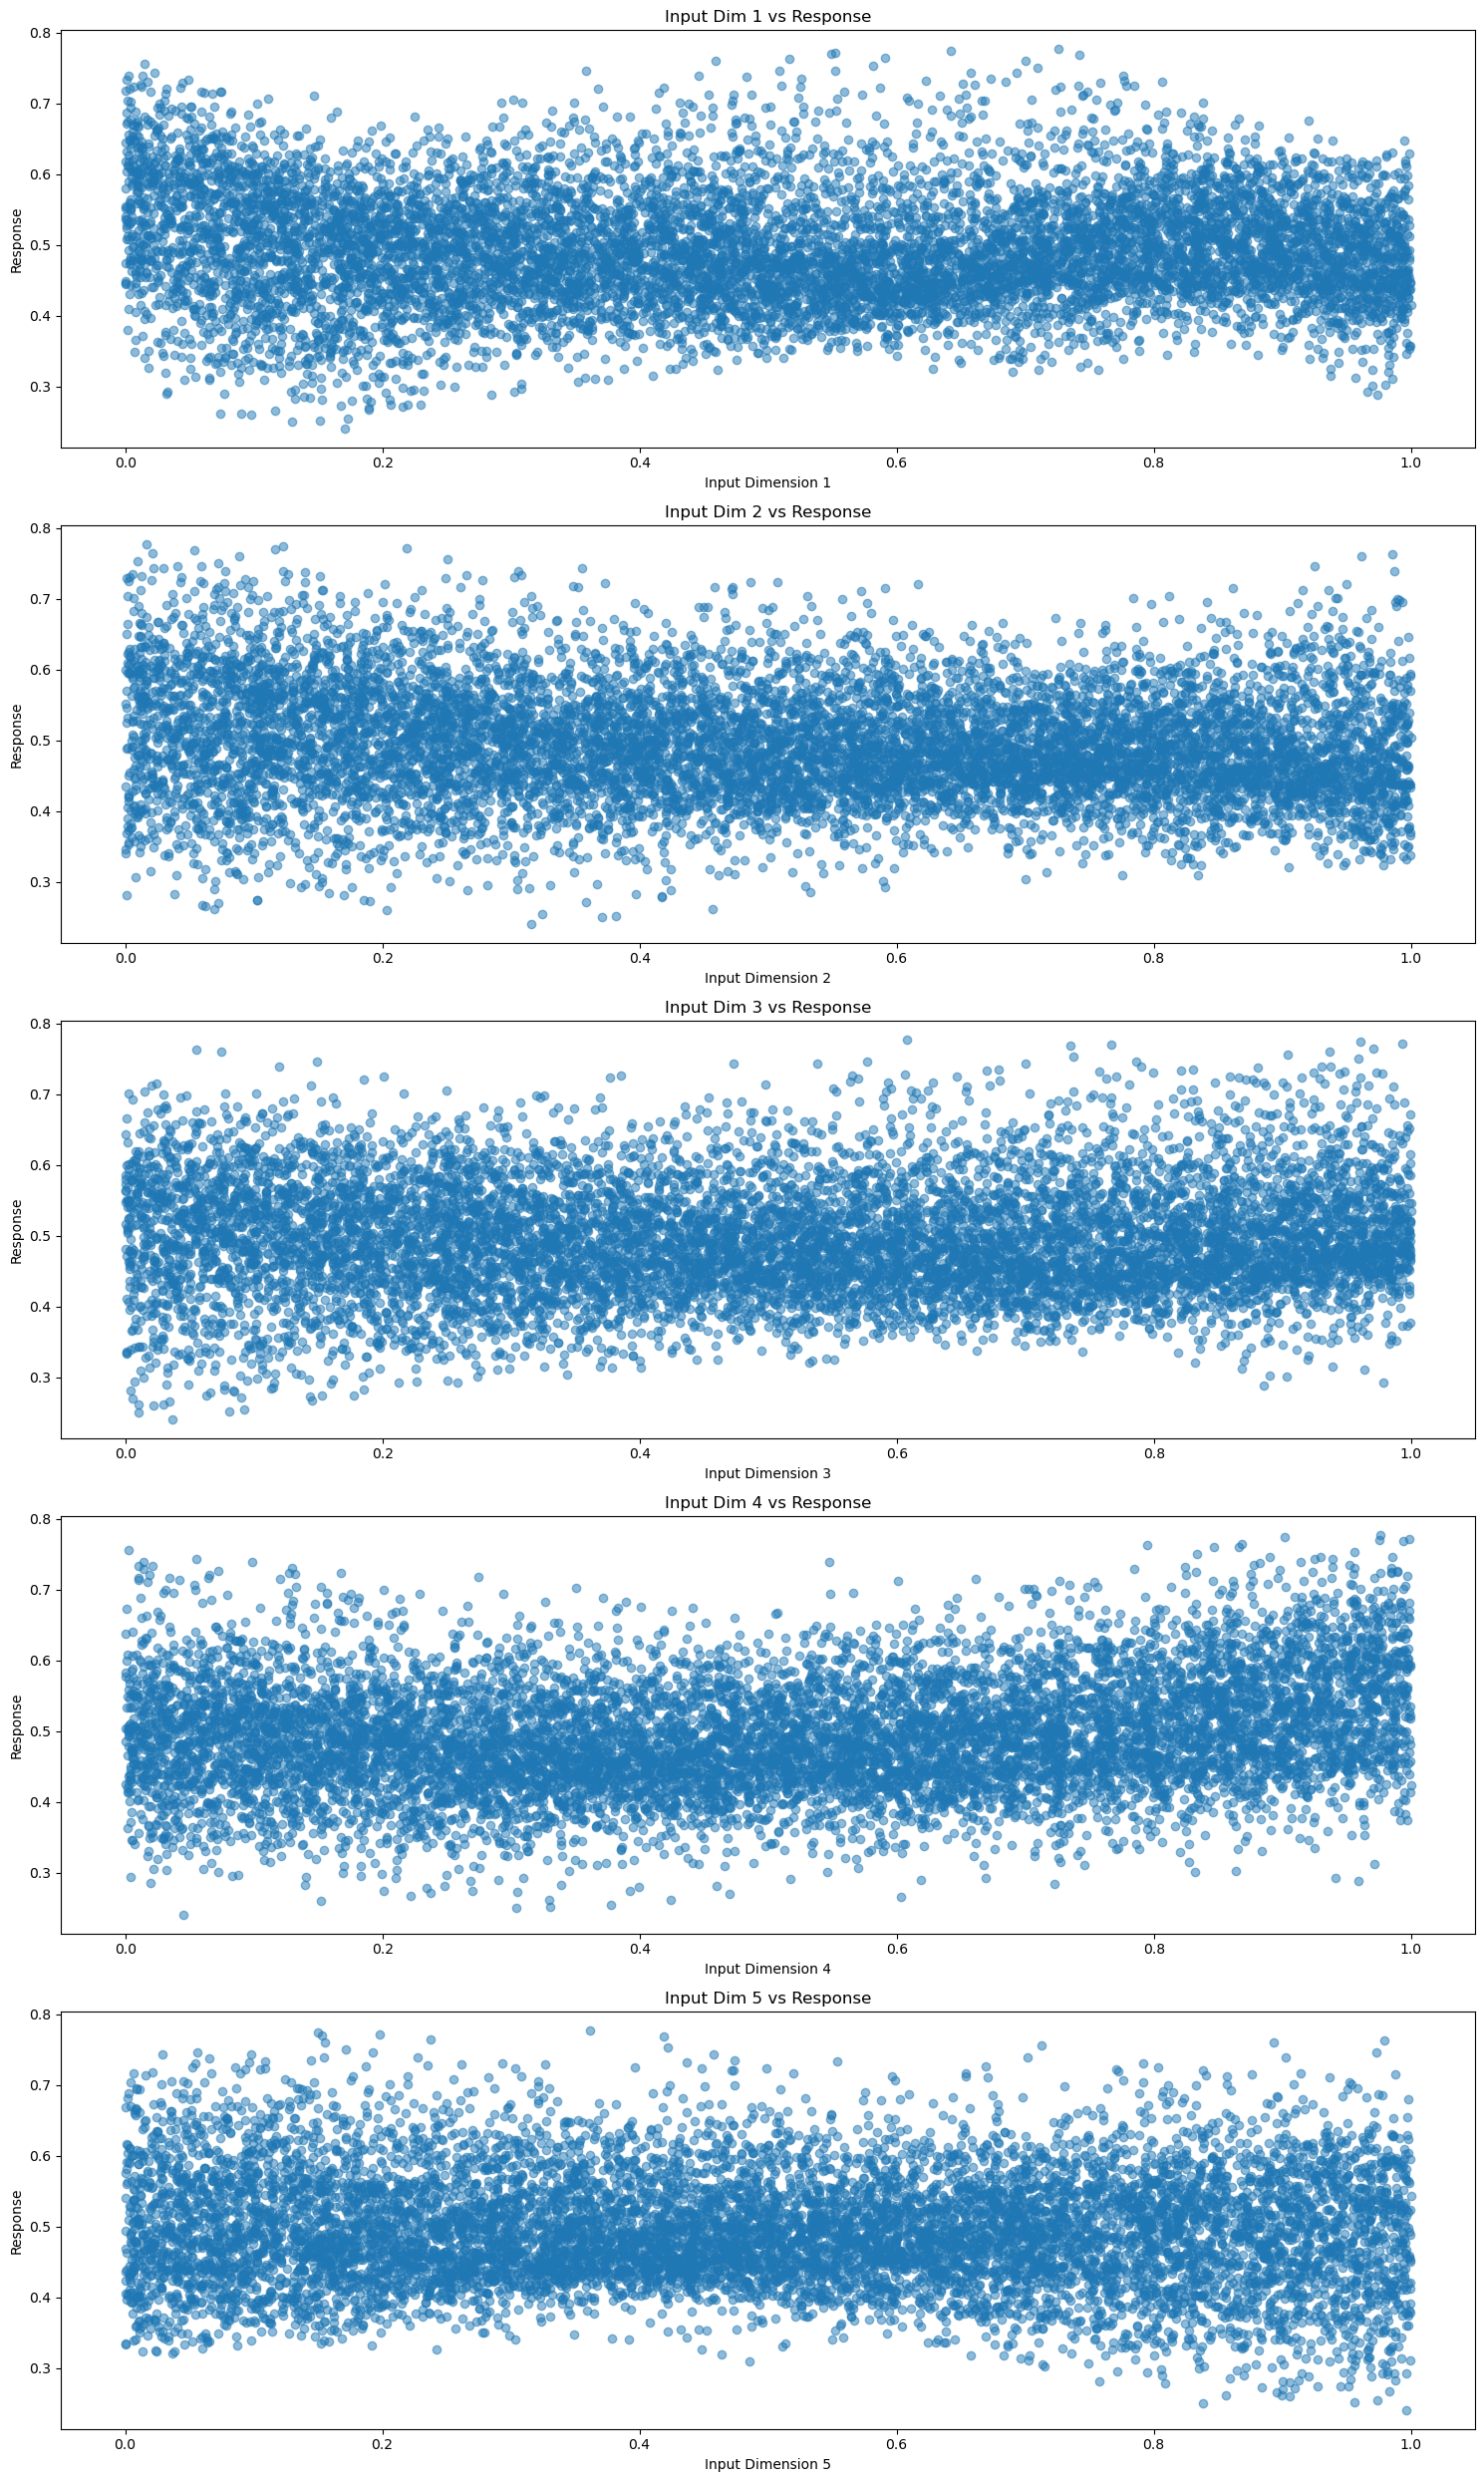

In [42]:
if example:
    X, y, b = simulate_gp_response("bernoulli-logit",10000, 0, 1.0, torch.tensor([(0.25, 0.50,0.75,1.00,1.25)]),1)

    os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
    # Convert to numpy for easier plotting
    X_np = X
    y_binary_np = y
    y_np = b

    # Calculate the number of rows and columns for the subplot grid
    n_features = X_np.shape[1]
    n_rows = int(np.ceil(n_features / 1))
    n_cols = min(n_features, 1)
    # Create a figure with subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Create scatter plots for each input dimension
    for i in range(n_features):
        axs[i].scatter(X_np[:, i], y_np, alpha=0.5)
        axs[i].set_xlabel(f'Input Dimension {i+1}')
        axs[i].set_ylabel('Response')
        axs[i].set_title(f'Input Dim {i+1} vs Response')

    # Remove any unused subplots
    for i in range(n_features, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()